<a href="https://colab.research.google.com/github/firdapdevi/Sentiment-Analysis-on-Goodreads-Books-Reviews/blob/main/Sentiment_Analysis_on_Goodreads_Books_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goodreads Books Review Rating Prediction
(https://www.kaggle.com/competitions/goodreads-books-reviews-290312/)
---

> Reviews are a good way to judge the quality of any product, whether it's books, clothes, technology, or anything else. When you want to buy something online these days, the first thing that comes to mind is the reviews from past buyers and the overall rating the product has received.

> Reader feedback, whether positive or negative, five stars or one star, will encourage the product owner to make improvements.

> Reader connection and engagement will be encouraged by book reviews, whether they be left on Amazon, Goodreads, or social media. Readers must determine whether or not other readers are enjoying the book.




Here are the columns of the dataset


*   book_id - Id of Book

*   review_id - Id of review

*   rating - rating from 0 to 5

*   review_text - review text

*   date_added - date added

*   date_updated - date updated

*   read_at - read at


*  started_at - started at


*   n_votes - no. of votes


*   n_comments - no. of comments



## Import Libraries

In [1]:
import sys
sys.path.append('/content/drive/MyDrive/Bootcamp/Day33 - Checkpoint 1')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os, sys
sys.path.append('../')
os.chdir('../')

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from wordcloud import WordCloud
from collections import Counter
import requests
import re
import torch
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.model_selection import train_test_split


from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from nltk.tokenize import TweetTokenizer

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

In [4]:
pip install wordcloud matplotlib pandas

In [5]:
pip install transformers

In [6]:
!pip install requests

## Import data from Kaggle


In [7]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle competitions download -c goodreads-books-reviews-290312

goodreads-books-reviews-290312.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!unzip goodreads-books-reviews-290312.zip -d "/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1"

Archive:  goodreads-books-reviews-290312.zip
replace /content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/goodreads_sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/goodreads_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/goodreads_train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## Exploratory Data Analysis (EDA)

### Statistics summary

#### Limit to get only 10k records of train data or 1% of each rating

In [10]:
data = pd.read_csv("/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/goodreads_train.csv")

total_records_needed = 10000

# Calculate the total number of records for each rating
rating_counts = data['rating'].value_counts()

# Calculate 1% of each rank's total number
rating_sample_sizes = (rating_counts * 0.01).astype(int)

# Here we scale down the sample sizes proportionally if the sum exceeds 10.000
if rating_sample_sizes.sum() > total_records_needed:
    scaling_factor = total_records_needed / rating_sample_sizes.sum()
    rating_sample_sizes = (rating_sample_sizes * scaling_factor).astype(int)


# Sampling data according to calculated sample sizes
samples = []
for rating, size in rating_sample_sizes.items():
    rating_samples = data[data['rating'] == rating].sample(n=size, random_state=1)
    samples.append(rating_samples)

# Concatenate all samples into a new DataFrame
data = pd.concat(samples)


print(rating_sample_sizes)

rating
4    3136
5    2650
3    1889
2     726
0     309
1     287
Name: count, dtype: int64


In [11]:
# Validate the number of records and proportions
print("Total records sampled:", data.shape[0])
print(data['rating'].value_counts(normalize=True))  # Check the percentage distribution

Total records sampled: 8997
rating
4    0.348561
5    0.294543
3    0.209959
2    0.080694
0    0.034345
1    0.031900
Name: proportion, dtype: float64


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8997 entries, 329091 to 884802
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       8997 non-null   object
 1   book_id       8997 non-null   int64 
 2   review_id     8997 non-null   object
 3   rating        8997 non-null   int64 
 4   review_text   8997 non-null   object
 5   date_added    8997 non-null   object
 6   date_updated  8997 non-null   object
 7   read_at       8095 non-null   object
 8   started_at    6229 non-null   object
 9   n_votes       8997 non-null   int64 
 10  n_comments    8997 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 843.5+ KB


In [13]:
data_sum_stats = data.describe(include='all').T.drop('count', axis=1)
data_sum_stats

,unique,top,freq,mean,std,min,25%,50%,75%,max
user_id,4648,aca760854b57ce2ec981df32e46dc96c,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
book_id,NaN,NaN,NaN,13506217.859175,9318323.24187,1.0,6388190.0,13458280.0,20569957.0,36196052.0
review_id,8997,d849310e1c90defd1821c2db194de969,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,NaN,NaN,NaN,3.690119,1.252212,0.0,3.0,4.0,5.0,5.0
review_text,8976,Review to come!,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_added,8997,Wed Sep 07 22:41:26 -0700 2011,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_updated,8994,Tue Dec 20 15:58:22 -0800 2016,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
read_at,5422,Thu Jan 01 00:00:00 -0800 2015,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
started_at,2597,Sat Jan 23 00:00:00 -0800 2016,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n_votes,NaN,NaN,NaN,3.304991,13.860293,0.0,0.0,0.0,2.0,367.0


In [14]:
data.columns

Index(['user_id', 'book_id', 'review_id', 'rating', 'review_text',
       'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes',
       'n_comments'],
      dtype='object')

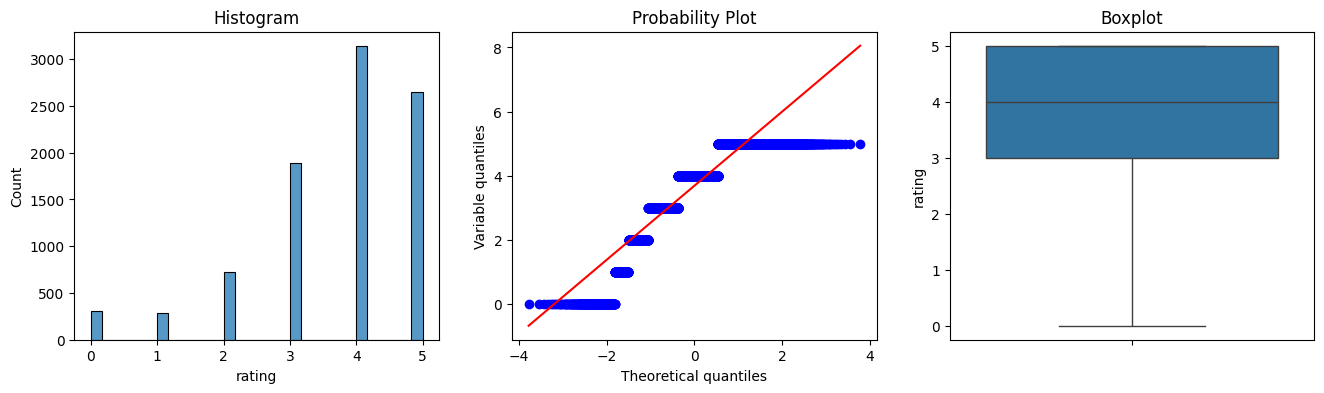

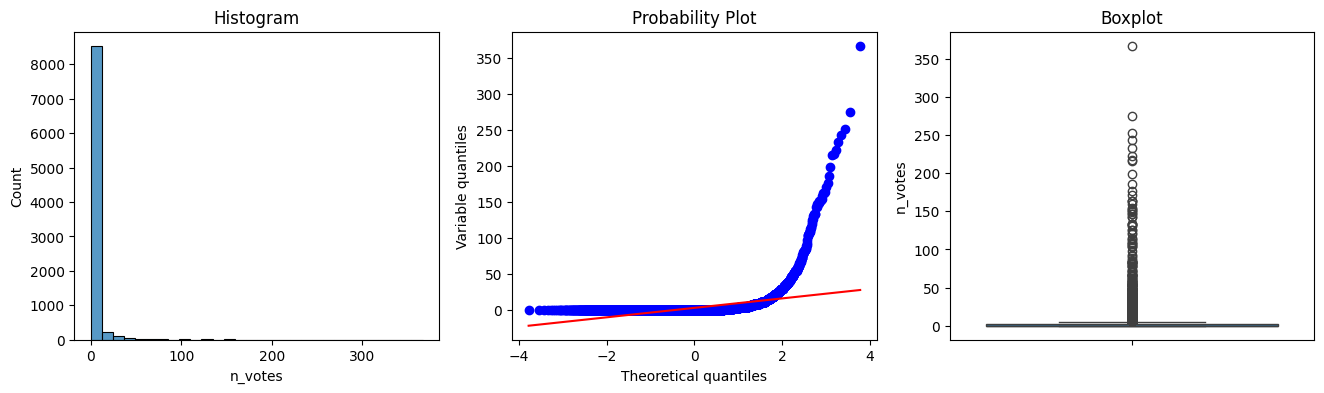

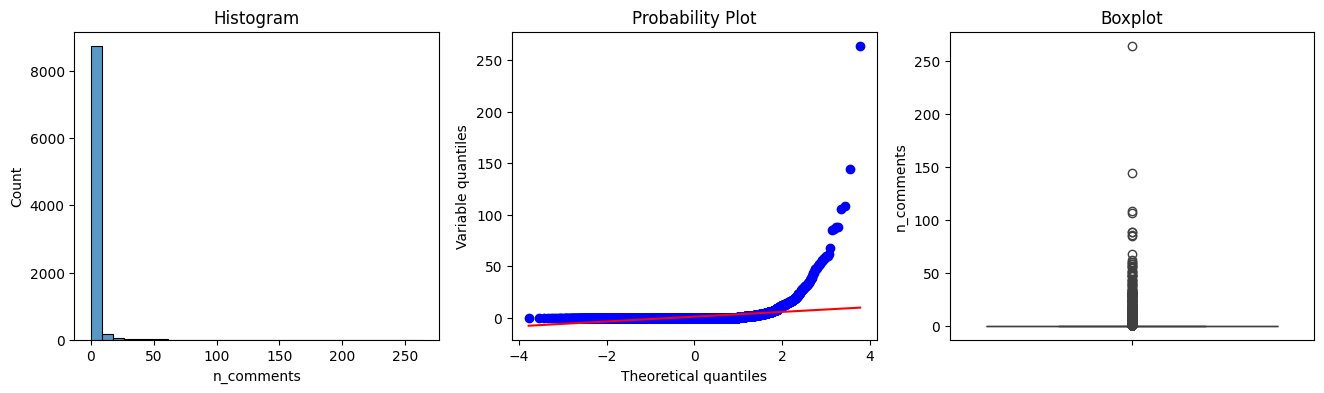

In [15]:
col_outlier = ['rating','n_votes','n_comments']

for col in col_outlier:
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(data[col], bins=30)
    plt.title('Histogram')

    # plot Q-Q
    plt.subplot(1, 3, 2)
    stats.probplot(data[col], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # box plot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=data[col])
    plt.title('Boxplot')

    plt.show()

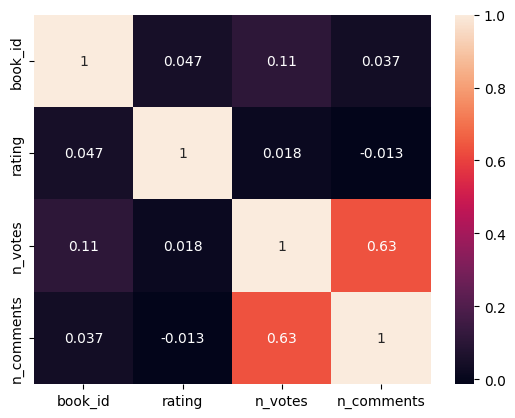

In [16]:
# Select only numeric columns for correlation calculation
numeric_train = data.select_dtypes(include=[np.number])

# Calculate the correlation matrix on just the numeric data
corrMatrix = numeric_train.corr()

# Create a heatmap
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(corrMatrix, annot=True)
plt.show()

### Visualizations

In [17]:
# setting id as index column
data.set_index("user_id", inplace = True)
data.set_index("book_id", inplace = True)
data.set_index("review_id", inplace = True)

#### Rating and Number of Votes Distribution

In [18]:
# Calculate the average number of votes and comments per rating
avg_data = data.groupby('rating')[['n_votes', 'n_comments']].mean().reset_index()

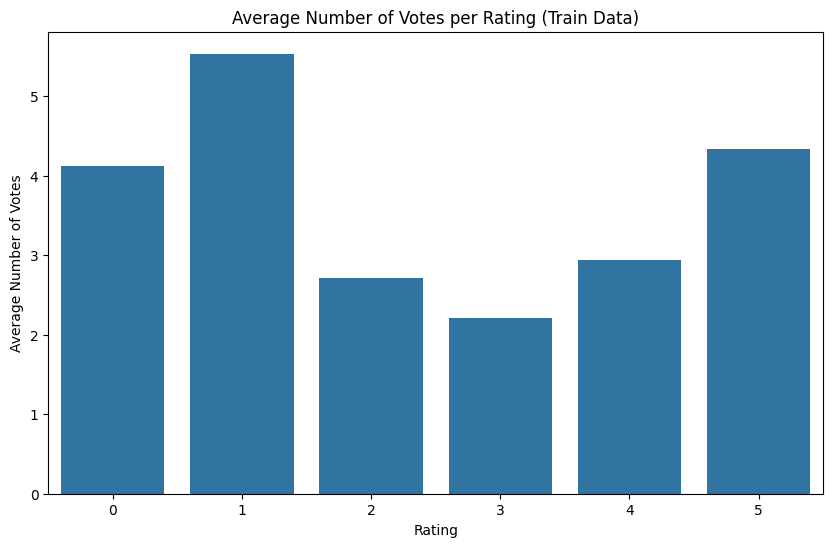

In [19]:
# Bar plot for train data
plt.figure(figsize=(10, 6))
sns.barplot(x='rating', y='n_votes', data=avg_data)
plt.title('Average Number of Votes per Rating (Train Data)')
plt.xlabel('Rating')
plt.ylabel('Average Number of Votes')
plt.show()

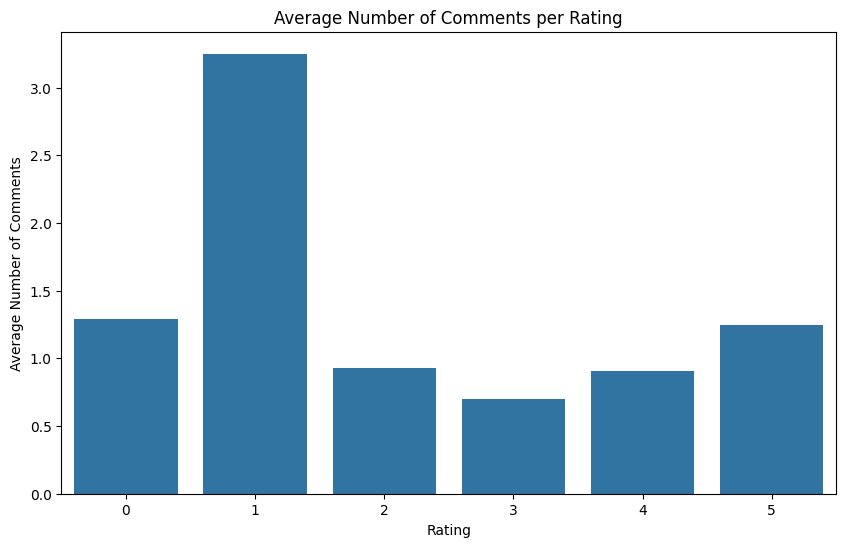

In [20]:
# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='rating', y='n_comments', data=avg_data)
plt.title('Average Number of Comments per Rating')
plt.xlabel('Rating')
plt.ylabel('Average Number of Comments')
plt.show()

#### Number of Votes and Number of Comments Distributions

In [21]:
# Check if there are any duplicate indices
print(data.index.duplicated().sum())

# If there are duplicates, reset the index
if data.index.duplicated().any():
    data.reset_index(drop=True, inplace=True)

0


In [22]:
print("Max n_votes:", data['n_votes'].max())
print("Max n_comments:", data['n_comments'].max())

Max n_votes: 367
Max n_comments: 264


In [23]:
votes_bins = [0, 50, 100, 500, 1000, data['n_votes'].max() + 1]
comments_bins = [0, 10, 50, 100, 500, data['n_comments'].max() + 1]

print("Votes bins:", votes_bins)
print("Comments bins:", comments_bins)


Votes bins: [0, 50, 100, 500, 1000, 368]
Comments bins: [0, 10, 50, 100, 500, 265]


In [24]:
# Check differences between bins to ensure they are all positive
print("Votes bins differences:", np.diff(votes_bins))
print("Comments bins differences:", np.diff(comments_bins))

Votes bins differences: [  50   50  400  500 -632]
Comments bins differences: [  10   40   50  400 -235]


In [25]:
# Manually set the last bin to be larger than any possible value in the dataset for both votes and comments
votes_bins = [0, 50, 100, 500, 1000]
comments_bins = [0, 10, 50, 100, 500]

# Extend the last bin beyond the highest predefined value if necessary
votes_bins.append(votes_bins[-1] + 500)
comments_bins.append(comments_bins[-1] + 500)

In [26]:
# Apply binning again with corrected bins
data['votes_bin'] = pd.cut(data['n_votes'], bins=votes_bins, right=False)
data['comments_bin'] = pd.cut(data['n_comments'], bins=comments_bins, right=False)

In [27]:
# Check new differences between bins to ensure all are positive
print("New Votes bins differences:", np.diff(votes_bins))
print("New Comments bins differences:", np.diff(comments_bins))

New Votes bins differences: [ 50  50 400 500 500]
New Comments bins differences: [ 10  40  50 400 500]


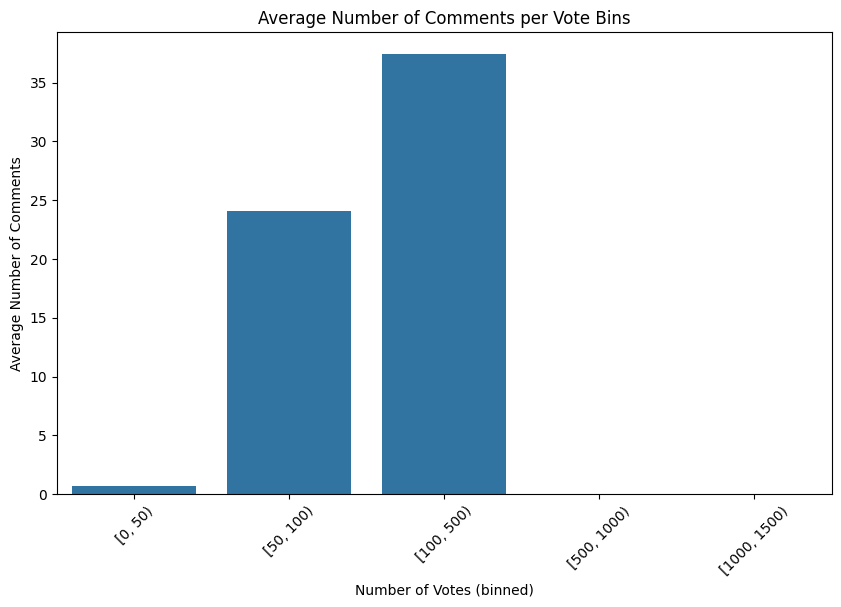

In [28]:
avg_comments_per_vote_bin = data.groupby('votes_bin')['n_comments'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='votes_bin', y='n_comments', data=avg_comments_per_vote_bin)
plt.title('Average Number of Comments per Vote Bins')
plt.xlabel('Number of Votes (binned)')
plt.ylabel('Average Number of Comments')
plt.xticks(rotation=45)
plt.show()

#### WordCloud

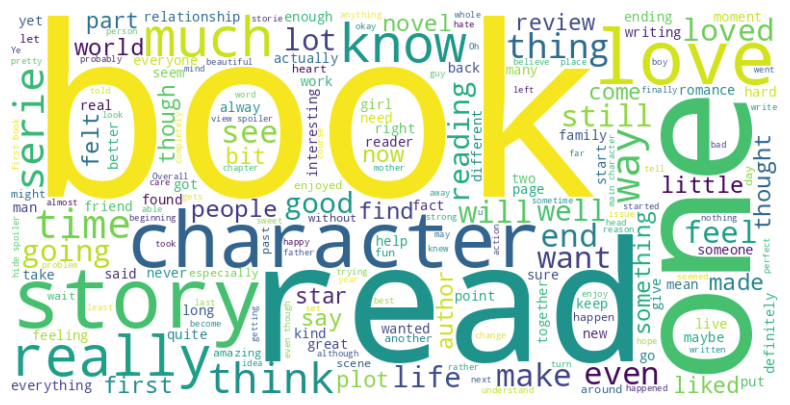

In [29]:
text = ' '.join(review for review in data['review_text'])

# Generate a word cloud image
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(text)

# Display the word cloud image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Top N Words

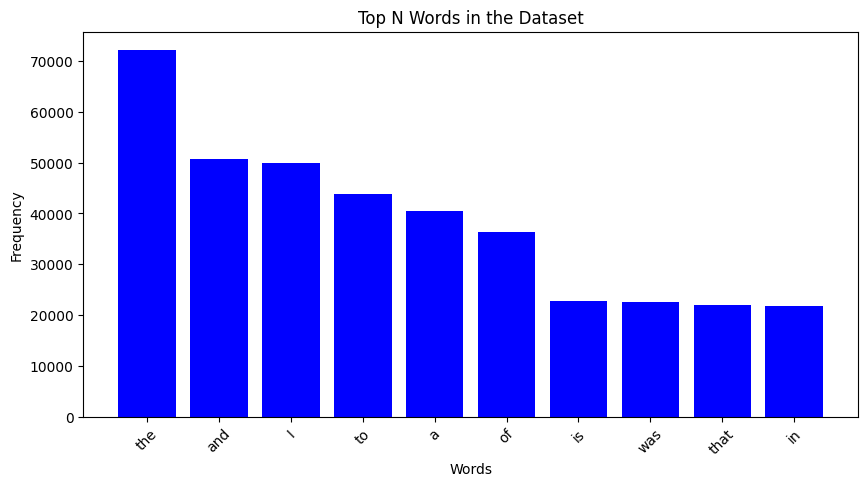

In [30]:
# Tokenize the text
words = text.split()

# Get frequencies of each word
word_counts = Counter(words)

# Determine the number of top words to display, e.g., top 10
top_n = 10
top_words = word_counts.most_common(top_n)
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# Plot
plt.figure(figsize=(10, 5))
plt.bar(top_words_df['Word'], top_words_df['Frequency'], color ='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top N Words in the Dataset')
plt.xticks(rotation=45)
plt.show()

## Sentiment Analysis

### **Label anotator sentiment**

To insert labels such as 'positive', 'neutral', or 'negative' for the DataFrame, we would typically go through a sentiment analysis process. This can be done either:


**1. Manually by reading through each text and assigning a label based on the sentiment conveyed**

For manual labeling, we could create a new column in the DataFrame and insert the labels directly.


**2. Automatically using a sentiment analysis tool or model**

For automatic labeling, we'd typically use a pre-trained sentiment analysis model from a library like NLTK, TextBlob, or through a service like Google Cloud Natural Language API.

In [31]:
def assign_sentiment_from_rating(rating):
    # Assign sentiment based on rating
    if rating in [4, 5]:
        return 'positive'
    elif rating in [0, 1, 2]:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'undefined'

In [32]:
data['sentiment'] = data['rating'].apply(assign_sentiment_from_rating)

In [33]:
print(data[['rating', 'sentiment']].tail())

                                  rating sentiment
review_id                                         
6402736b02ce52e8119953fa7fab6c90       1  negative
37732c4eba22c984443ba5e375cda22e       1  negative
c1293aff9a1b26e6495efb2632e3405d       1  negative
f894a569eec2f85411135db0018c2871       1  negative
d849310e1c90defd1821c2db194de969       1  negative


### Preprocess text

In [34]:
data.columns

Index(['rating', 'review_text', 'date_added', 'date_updated', 'read_at',
       'started_at', 'n_votes', 'n_comments', 'votes_bin', 'comments_bin',
       'sentiment'],
      dtype='object')

In [35]:
# Specify columns to delete
columns_to_delete = ['date_added', 'date_updated', 'read_at', 'started_at',
                     'n_votes', 'n_comments', 'votes_bin', 'comments_bin',
                     'rating']

data = data.drop(columns=columns_to_delete)

data.head(10)

,review_text,sentiment
review_id,,
dcdfc4fca4e42ad34a1396d6c85d9e69,I figured this was a trend of all the mend tha...,positive
2f7f06bbce07261f1c639a0473e9ca06,So much fun! Not sure I'm going to like as muc...,positive
f63d6177217080f67b2ffa005e662917,Rainy Dey heads off to college as a freshman. ...,positive
6e87495c835caafdd6e1ee3d5fceb7d1,So you know what I was just thinking today? Ho...,positive
396d2fa0a1dd1802440462ecc4665fd1,A good continuation from the previous book. Br...,positive
e484a03028db34f7bcd4d26e771f839c,"You know, I resisted the whole vampire/werewol...",positive
49c77fbaa4558f41fbf022cd37b2eea4,"An interesting retelling of Snow White. Sure, ...",positive
43ce000161e07014c1d805471cbf73a1,"Like so many of the mysteries I love, this one...",positive
106dca9e8f2ad428ce5701293fafb0a0,The German edition cover is so much better. An...,positive


In [36]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [37]:
# Set random seed
set_seed(20052024)

In [38]:
def cleaning_text(text):
    # remove url
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r'', text)

    # remove hashtags
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', text)

    # remove mention handle user (@)
    text = re.sub(r'@[\w]*', ' ', text)

    # remove emojis
    emoji_pattern = re.compile(
        '['
        '\U0001F600-\U0001F64F'  # emoticons
        '\U0001F300-\U0001F5FF'  # symbols & pictographs
        '\U0001F680-\U0001F6FF'  # transport & map symbols
        '\U0001F700-\U0001F77F'  # alchemical symbols
        '\U0001F780-\U0001F7FF'  # Geometric Shapes Extended
        '\U0001F800-\U0001F8FF'  # Supplemental Arrows-C
        '\U0001F900-\U0001F9FF'  # Supplemental Symbols and Pictographs
        '\U0001FA00-\U0001FA6F'  # Chess Symbols
        '\U0001FA70-\U0001FAFF'  # Symbols and Pictographs Extended-A
        '\U00002702-\U000027B0'  # Dingbats
        '\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)

    # remove punctuation
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for x in text.lower():
        if x in punctuations:
            text = text.replace(x, " ")

    # remove extra whitespace
    text = ' '.join(text.split())

    # lowercase
    text = text.lower()
    return text

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# CONSTRUCT STOPWORDS
alir3z4_stopword = "https://github.com/Alir3z4/stop-words/blob/master/english.txt"
iso_stopword = "https://github.com/stopwords-iso/stopwords-en/blob/master/stopwords-en.txt"
bbalet_stopword = "https://github.com/bbalet/stopwords/blob/master/_stopwords.txt"
igorbrigadir_stopword = "https://github.com/igorbrigadir/stopwords/blob/master/en/terrier.txt"
naimdjon_stopword = "https://github.com/naimdjon/stopwords/blob/master/stopwords.txt"
saurabbhsp_stopword = "https://github.com/saurabbhsp/stopwords/blob/master/English.txt"
sanjaalcorps_stopword = "https://github.com/sanjaalcorps/EnglishStopWords/blob/master/stop_words_eng.csv"
cihanhelin_stopword = "https://github.com/cihanhelin/NLTK-s-list-of-english-stopwords/blob/main/NLTK-s-list-of-english-stopwords"
machouz1_stopword = "https://github.com/machouz/stopwords/blob/master/stopwords/stop-words_english_1_en.txt"
machouz2_stopword = "https://github.com/machouz/stopwords/blob/master/stopwords/stop-words_english_2_en.txt"
machouz3_stopword = "https://github.com/machouz/stopwords/blob/master/stopwords/stop-words_english_3_en.txt"
machouz4_stopword = "https://github.com/machouz/stopwords/blob/master/stopwords/stop-words_english_4_google_en.txt"
machouz5_stopword = "https://github.com/machouz/stopwords/blob/master/stopwords/stop-words_english_5_en.txt"
machouz6_stopword = "https://github.com/machouz/stopwords/blob/master/stopwords/stop-words_english_6_en.txt"
nltk_stopword = stopwords.words('english')

# create path url for each stopword
path_stopwords = [alir3z4_stopword, iso_stopword, bbalet_stopword, igorbrigadir_stopword,
                  naimdjon_stopword, saurabbhsp_stopword, sanjaalcorps_stopword, cihanhelin_stopword,
                  machouz1_stopword, machouz2_stopword, machouz3_stopword, machouz4_stopword,
                  machouz5_stopword, machouz6_stopword]

# combine stopwords
stopwords_l = nltk_stopword
for path in path_stopwords:
    response = requests.get(path)
    stopwords_l += response.text.split('\n')

custom_st = '''
A fun, fast paced science fiction thriller. I read it in 2 nights and couldn't put it down.
The book is about the quantum theory of many worlds which states that all decisions we make
throughout our lives basically create branches,
and that each possible path through the decision tree can be thought of as a parallel world.
And in this book, someone invents a way to switch between these worlds.
This was nicely alluded to/foreshadowed in this quote: \n
"I think about all the choices we've made that created this moment.
Us sitting here together at this beautiful table.
Then I think of all the possible events that could have stopped this moment from ever happening,
and it all feels, I don't know..." "What?" "So fragile."
Now he becomes thoughtful for a moment. He says finally,
"It's terrifying when you consider that every thought we have, every choice we could possibly make,
branches into a new world." \n (view spoiler)
[This book can't be discussed without spoilers. It is a book about choice and regret.
Ever regret not chasing the girl of your dreams so you can focus on your career?
Well Jason2 made that choice and then did regret it. Clearly the author is trying to tell us to optimize for happiness -
to be that second rate physics teacher at a community college if it means you can have a happy life.
I'm being snarky because while there is certainly something to that, you also have to have meaning in your life that comes from within.
I thought the book was a little shallow on this dimension. In fact, all the characters were fairly shallow.
Daniela was the perfect wife. Ryan the perfect antithesis of Jason. Amanda the perfect loyal traveling companion, etc.
This, plus the fact that the book was weak on the science are what led me to take a few stars off -
but I'd still read it again if I could go back in time - was a very fun and engaging read. \n
If you want to really minimize regret, you have to live your life to avoid it in the first place.
Regret can't be hacked, which is kind of the point of the book.
My favorite book about regret is Remains of the Day. I do really like the visualization of the decision tree though - that is a powerful concept. \n
"Every moment, every breath, contains a choice. But life is imperfect. We make the wrong choices. So we end up living in a state of perpetual regret,
and is there anything worse? I built something that could actually eradicate regret. Let you find worlds where you made the right choice."
Daniela says, "Life doesn't work that way. You live with your choices and learn. You don't cheat the system.
'''

# create dictionary with unique stopword
st_words = set(stopwords_l)
custom_stopword = set(custom_st.split())

# result stopwords
stop_words = st_words | custom_stopword
print(f'Stopwords: {list(stop_words)[:5]}')
# remove stopwords
from nltk import word_tokenize, sent_tokenize

def remove_stopword(text, stop_words=stop_words):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Stopwords: ['', '.jXTShb [data-component="trailingAction"]{margin-right:-4px;}/*!sc*/', 'data-styled.g9[id="types__StyledButton-sc-ws60qy-0"]{content:"blmaBs,hkJzmn,hILMMl,ivbpoP,hviaoI,jXTShb,fAkXQN,gfKkfV,dTgfec,pyyxt,fmvlPZ,bcQZPI,dGDIQc,"}/*!sc*/', '      <span data-view-component="true" class="progress-pjax-loader Progress position-fixed width-full">', '    <ul aria-labelledby="action-menu-9b3d7301-4479-4715-91d5-8f23e5ff7614-button" id="action-menu-9b3d7301-4479-4715-91d5-8f23e5ff7614-list" role="menu" data-view-component="true" class="ActionListWrap--inset ActionListWrap">']


In [39]:
# pipeline preprocess
def preprocess(text):
    # cleaning text and lowercase
    output = cleaning_text(text)

    # remove stopwords
    output = remove_stopword(output)

    return output

In [40]:
# implement preprocessing

# Copy the datasets
preprocessed_data = data.copy()

# Apply the preprocessing function
preprocessed_data['review_text'] = data['review_text'].map(preprocess)

print(preprocessed_data['review_text'].head())

review_id
dcdfc4fca4e42ad34a1396d6c85d9e69    figured trend mend involved gwen glad reached ...
2f7f06bbce07261f1c639a0473e9ca06    much sure going much ruby red trilogy sooooo l...
f63d6177217080f67b2ffa005e662917    rainy dey heads freshman mom recently passed a...
6e87495c835caafdd6e1ee3d5fceb7d1    know thinking today series entertaining creati...
396d2fa0a1dd1802440462ecc4665fd1    good continuation previous brings familiar exp...
Name: review_text, dtype: object


In [41]:
# Define file paths
csv_file_path = '/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/preprocessed_data.csv'

# Save the train dataset
df = pd.DataFrame(preprocessed_data)
df.to_csv(csv_file_path, sep=';', index=False, header=True)
print(f'Preprocessed data has been saved to {csv_file_path}')

Preprocessed data has been saved to /content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/preprocessed_data.csv


In [42]:
# load processed dataset into pandas
preprocessed_data = pd.read_csv('/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/preprocessed_data.csv', sep=';')
preprocessed_data.tail(10)

,review_text,sentiment
8987,understand 4star ratings look suspiciously sim...,negative
8988,whattheheck enough enough got excitement peopl...,negative
8989,man stupid premise sort embarrassingly ridicul...,negative
8990,going review blog much going bash say skipped ...,negative
8991,dnf 62 person compared wallbanger wish battery...,negative
8992,christ dregs god name review come highlights,negative
8993,know total sucker,negative
8994,1 star highlander historical romance,negative
8995,bleh snoozefest glad done,negative
8996,started series came across quite number fair r...,negative


In [43]:
preprocessed_data[preprocessed_data['sentiment'] == "neutral"]

,review_text,sentiment
5786,glance genre young adult angels vampires love ...,neutral
5787,sure liked enough continue series shall see st...,neutral
5788,4 ending spoil deliver amazing plot twists ent...,neutral
5789,worst series far ending awful awful rest ok me...,neutral
5790,ok zoey ho bag mean srsly guys need sexy erik ...,neutral
...,...,...
7670,compared hathaway series accidental romance oc...,neutral
7671,roger zelazny best short stories wrote lot nov...,neutral
7672,sure say took two months wanted another stand ...,neutral
7673,connor definitely style sure fan descriptions ...,neutral


In [44]:
texts = preprocessed_data['review_text'].tolist()
labels = preprocessed_data['sentiment'].tolist()

### Modeling

##### Load distilbert-base-multilingual-cased-sentiments-student

In [45]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("distilbert/distilbert-base-uncased")

# # Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [46]:
model

DistilBertForMaskedLM(
  (activation): GELUActivation()
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.

In [47]:
count_param(model)

66985530

##### Preparing the Input and Making Predictions

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = '/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/preprocessed_data.csv'
df = pd.read_csv(file_path, sep=',')

# Split the dataset into train, test, and validation sets
train_df, test_valid_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, valid_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)

# Save the splits as TSV files
train_df.to_csv('/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/train.tsv', sep='\t', index=False)
test_df.to_csv('/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/test.tsv', sep='\t', index=False)
valid_df.to_csv('/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/valid.tsv', sep='\t', index=False)

In [49]:
train_dataset_path = '/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/train.tsv'
valid_dataset_path = '/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/valid.tsv'
test_dataset_path = '/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/train.tsv'

###### Set up label mappings

In [50]:
LABEL2INDEX = {'negative': 0, 'neutral': 1, 'positive': 2}
INDEX2LABEL = {0: 'negative', 1: 'neutral', 2: 'positive'}

For the XLM-RoBERTa model, we should tokenize text data using the XLM-RoBERTa tokenizer

In [51]:
# Load the data from TSV files into pandas DataFrames
train_df = pd.read_csv(train_dataset_path, delimiter=';')
valid_df = pd.read_csv(valid_dataset_path, delimiter=';')
test_df = pd.read_csv(test_dataset_path, delimiter=';')

In [52]:
# Convert textual labels to numeric labels using LABEL2INDEX
train_df['label'] = train_df['sentiment'].map(LABEL2INDEX).astype(int)
valid_df['label'] = valid_df['sentiment'].map(LABEL2INDEX).astype(int)
test_df['label'] = test_df['sentiment'].map(LABEL2INDEX).astype(int)

In [58]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import AutoTokenizer, DistilBertForSequenceClassification, AdamW
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Ensure text is a string and handle NaN values
        if not isinstance(text, str):
            text = str(text)
        if pd.isna(label):
            label = 0  # Default label

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

train_dataset = SentimentDataset(train_df['review_text'], train_df['label'].map(LABEL2INDEX), tokenizer, max_len=512)
valid_dataset = SentimentDataset(valid_df['review_text'], valid_df['label'].map(LABEL2INDEX), tokenizer, max_len=512)
test_dataset = SentimentDataset(test_df['review_text'], test_df['label'].map(LABEL2INDEX), tokenizer, max_len=512)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=4)  # Reduced batch size
valid_loader = DataLoader(valid_dataset, batch_size=6, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=False, num_workers=4)

In [59]:
w2i, i2w = LABEL2INDEX, INDEX2LABEL
print(w2i)
print(i2w)

{'negative': 0, 'neutral': 1, 'positive': 2}
{0: 'negative', 1: 'neutral', 2: 'positive'}


###### Test model on sample sentences

In [60]:
# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

model.eval()

# Example text
text = '1 star highlander historical romance.'

# Tokenize the text
subwords = tokenizer.encode(text, return_tensors='pt').to(model.device)

# Get the logits from the model
output = model(subwords)
logits = output.logits

# Print the shape of logits for debugging
print(f"Shape of logits: {logits.shape}")

# Get the top label and its confidence
topk = torch.topk(logits, k=1, dim=-1)
label = topk[1].squeeze(dim=-1).item()
confidence = F.softmax(logits, dim=-1).squeeze()[label] * 100

# Print the result
print(f'Text: {text} | Label : {i2w[label]} ({confidence:.3f}%)')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Shape of logits: torch.Size([1, 2])
Text: 1 star highlander historical romance. | Label : neutral (53.680%)


In [61]:
text = 'started interesting thriller woman run mysterious pass story took strange twists turns ends talky talky reveal.'

# Tokenize the text
subwords = tokenizer.encode(text, return_tensors='pt').to(model.device)

# Get the logits from the model
output = model(subwords)
logits = output.logits

# Print the shape of logits for debugging
print(f"Shape of logits: {logits.shape}")

# Get the top label and its confidence
topk = torch.topk(logits, k=1, dim=-1)
label = topk[1].squeeze(dim=-1).item()
confidence = F.softmax(logits, dim=-1).squeeze()[label] * 100

# Print the result
print(f'Text: {text} | Label : {i2w[label]} ({confidence:.3f}%)')


Shape of logits: torch.Size([1, 2])
Text: started interesting thriller woman run mysterious pass story took strange twists turns ends talky talky reveal. | Label : negative (50.700%)


#### Fine tuning & evaluation

In [62]:
import shutil

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [63]:
!nvidia-smi

Mon May 20 16:25:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0              28W /  70W |    395MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [64]:
import torch
torch.cuda.is_available()

True

In [65]:
import torch
torch.cuda.empty_cache()

In [66]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

#### Training distilbert-base-multilingual-cased-sentiments-student for Sentiment Analysis

In [67]:
train_df.dropna(subset=['label'], inplace=True)

In [68]:
# Check for NaN values in the DataFrame
print("NaN in texts:", train_df['review_text'].isna().sum())
print("NaN in labels:", train_df['label'].isna().sum())

# Drop rows where any of the necessary columns are NaN
train_df.dropna(subset=['review_text', 'label'], inplace=True)


NaN in texts: 7
NaN in labels: 0


##### Load the Model and Optimizer

In [69]:
from transformers import DistilBertForSequenceClassification, AdamW
import torch
from tqdm import tqdm

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to('cuda')

# Initialize the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Function to get learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


##### Define forward_sequence_classification Function

In [70]:
# Define the forward function
def forward_sequence_classification(model, batch_data, i2w, device):
    input_ids = batch_data['input_ids'].to(device)
    attention_mask = batch_data['attention_mask'].to(device)
    labels = batch_data['labels'].to(device)

    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss
    logits = outputs.logits

    batch_hyp = torch.argmax(logits, dim=1).cpu().numpy()
    batch_label = labels.cpu().numpy()

    return loss, batch_hyp, batch_label

##### Define metrics calculation functions

metrics calculation functions

In [71]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd

# Define the metrics calculation functions
def document_sentiment_metrics_fn(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


metrics to string functions

In [72]:
def metrics_to_string(metrics):
    return "Acc: {:.4f}, Prec: {:.4f}, Rec: {:.4f}, F1: {:.4f}".format(
        metrics['accuracy'],
        metrics['precision'],
        metrics['recall'],
        metrics['f1']
    )


##### Training and evaluation loop

In [73]:
# Training loop
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data, i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss += tr_loss

        # Calculate metrics
        list_hyp += list(batch_hyp)
        list_label += list(batch_label)

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format(
            (epoch+1), total_train_loss/(i+1), get_lr(optimizer)
        ))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format(
        (epoch+1), total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)
    ))

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data, i2w=i2w, device='cuda')

        # Calculate total loss
        valid_loss = loss.item()
        total_loss += valid_loss

        # Calculate evaluation metrics
        list_hyp += list(batch_hyp)
        list_label += list(batch_label)
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1), total_loss/(i+1), metrics_to_string(metrics)))


  0%|          | 0/1200 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 1) TRAIN LOSS:0.0060 LR:0.00002000: 100%|██████████| 1200/1200 [05:46<00:00,  3.46it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(Epoch 1) TRAIN LOSS:0.0060 Acc: 0.9992, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 LR:0.00002000


  0%|          | 0/150 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000:   1%|          | 1/150 [00:00<00:52,  2.82it/s]/usr/local/l

(Epoch 1) VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


  0%|          | 0/1200 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 2) TRAIN LOSS:0.0000 LR:0.00002000: 100%|██████████| 1200/1200 [05:53<00:00,  3.39it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(Epoch 2) TRAIN LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 LR:0.00002000


  0%|          | 0/150 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000:   1%|          | 1/150 [00:00<00:48,  3.10it/s]/usr/local/l

(Epoch 2) VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


  0%|          | 0/1200 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 3) TRAIN LOSS:0.0000 LR:0.00002000: 100%|██████████| 1200/1200 [05:53<00:00,  3.40it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(Epoch 3) TRAIN LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 LR:0.00002000


  0%|          | 0/150 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000:   1%|          | 1/150 [00:00<00:51,  2.91it/s]/usr/local/l

(Epoch 3) VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


  0%|          | 0/1200 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 4) TRAIN LOSS:0.0000 LR:0.00002000: 100%|██████████| 1200/1200 [05:53<00:00,  3.39it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(Epoch 4) TRAIN LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 LR:0.00002000


  0%|          | 0/150 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000:   1%|          | 1/150 [00:00<00:51,  2.92it/s]/usr/local/l

(Epoch 4) VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


  0%|          | 0/1200 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 5) TRAIN LOSS:0.0000 LR:0.00002000: 100%|██████████| 1200/1200 [05:53<00:00,  3.39it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(Epoch 5) TRAIN LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 LR:0.00002000


  0%|          | 0/150 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000:   1%|          | 1/150 [00:00<00:49,  2.99it/s]/usr/local/l

(Epoch 5) VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


  0%|          | 0/1200 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 6) TRAIN LOSS:0.0000 LR:0.00002000: 100%|██████████| 1200/1200 [05:54<00:00,  3.39it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(Epoch 6) TRAIN LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 LR:0.00002000


  0%|          | 0/150 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000:   1%|          | 1/150 [00:00<00:51,  2.91it/s]/usr/local/l

(Epoch 6) VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


  0%|          | 0/1200 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 7) TRAIN LOSS:0.0000 LR:0.00002000: 100%|██████████| 1200/1200 [05:54<00:00,  3.39it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(Epoch 7) TRAIN LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 LR:0.00002000


  0%|          | 0/150 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000:   1%|          | 1/150 [00:00<00:49,  3.01it/s]/usr/local/l

(Epoch 7) VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


  0%|          | 0/1200 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 8) TRAIN LOSS:0.0000 LR:0.00002000: 100%|██████████| 1200/1200 [05:53<00:00,  3.39it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(Epoch 8) TRAIN LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 LR:0.00002000


  0%|          | 0/150 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000:   1%|          | 1/150 [00:00<00:47,  3.11it/s]/usr/local/l

(Epoch 8) VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


  0%|          | 0/1200 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 9) TRAIN LOSS:0.0000 LR:0.00002000: 100%|██████████| 1200/1200 [05:54<00:00,  3.39it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(Epoch 9) TRAIN LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 LR:0.00002000


  0%|          | 0/150 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000:   1%|          | 1/150 [00:00<00:52,  2.83it/s]/usr/local/l

(Epoch 9) VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000


  0%|          | 0/1200 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
(Epoch 10) TRAIN LOSS:0.0000 LR:0.00002000: 100%|██████████| 1200/1200 [05:53<00:00,  3.39it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(Epoch 10) TRAIN LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000 LR:0.00002000


  0%|          | 0/150 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000:   1%|          | 1/150 [00:00<00:48,  3.04it/s]/usr/local/l

(Epoch 10) VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

list_hyp = []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data, i2w=LABEL2INDEX, device='cuda')
    list_hyp += list(batch_hyp)

# Save predictions to a file
df = pd.DataFrame({'label': list_hyp}).reset_index()
df.to_csv('pred.txt', index=False)

print(df)

  0%|          | 0/1200 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1200/1200 [02:10<00:00,  9.20it/s]

      index  label
0         0      0
1         1      0
2         2      0
3         3      0
4         4      0
...     ...    ...
7192   7192      0
7193   7193      0
7194   7194      0
7195   7195      0
7196   7196      0

[7197 rows x 2 columns]


In [75]:
torch.save(model, '/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/distilbert_base_multilingual_model.pth')

##### Test fine-tuned model on sample sentences

In [76]:
# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

model.eval()

# Example text
text = '1 star highlander historical romance.'

# Tokenize the text
subwords = tokenizer.encode(text, return_tensors='pt').to(model.device)

# Get the logits from the model
output = model(subwords)
logits = output.logits

# Print the shape of logits for debugging
print(f"Shape of logits: {logits.shape}")

# Get the top label and its confidence
topk = torch.topk(logits, k=1, dim=-1)
label = topk[1].squeeze(dim=-1).item()
confidence = F.softmax(logits, dim=-1).squeeze()[label] * 100

# Print the result
print(f'Text: {text} | Label : {i2w[label]} ({confidence:.3f}%)')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Shape of logits: torch.Size([1, 2])
Text: 1 star highlander historical romance. | Label : negative (52.203%)


In [77]:
text = 'started interesting thriller woman run mysterious pass story took strange twists turns ends talky talky reveal.'

# Tokenize the text
subwords = tokenizer.encode(text, return_tensors='pt').to(model.device)

# Get the logits from the model
output = model(subwords)
logits = output.logits

# Print the shape of logits for debugging
print(f"Shape of logits: {logits.shape}")

# Get the top label and its confidence
topk = torch.topk(logits, k=1, dim=-1)
label = topk[1].squeeze(dim=-1).item()
confidence = F.softmax(logits, dim=-1).squeeze()[label] * 100

# Print the result
print(f'Text: {text} | Label : {i2w[label]} ({confidence:.3f}%)')


Shape of logits: torch.Size([1, 2])
Text: started interesting thriller woman run mysterious pass story took strange twists turns ends talky talky reveal. | Label : negative (54.174%)


In [ ]:
text = 'An interesting retelling of Snow White.'

# Tokenize the text
subwords = tokenizer.encode(text, return_tensors='pt').to(model.device)

# Get the logits from the model
output = model(subwords)
logits = output.logits

# Print the shape of logits for debugging
print(f"Shape of logits: {logits.shape}")

# Get the top label and its confidence
topk = torch.topk(logits, k=1, dim=-1)
label = topk[1].squeeze(dim=-1).item()
confidence = F.softmax(logits, dim=-1).squeeze()[label] * 100

# Print the result
print(f'Text: {text} | Label : {i2w[label]} ({confidence:.3f}%)')


#### Hyperparameter Optimization

In [78]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.8 MB/s eta 0:00:00


In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to be tuned
    lr = trial.suggest_loguniform('lr', 1e-5, 5e-5)
    batch_size = trial.suggest_categorical('batch_size', [4, 6, 8])

    # Initialize the model
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
    model.to('cuda')

    # Initialize the optimizer
    optimizer = AdamW(model.parameters(), lr=lr)

    # Dataloaders with the new batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Training loop
    n_epochs = 3  # Use a smaller number of epochs for hyperparameter tuning
    for epoch in range(n_epochs):
        model.train()
        torch.set_grad_enabled(True)

        total_train_loss = 0
        list_hyp, list_label = [], []

        train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
        for i, batch_data in enumerate(train_pbar):
            # Forward model
            loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data, device='cuda')

            # Update model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tr_loss = loss.item()
            total_train_loss += tr_loss

            # Calculate metrics
            list_hyp += list(batch_hyp)
            list_label += list(batch_label)

            train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format(
                (epoch+1), total_train_loss/(i+1), lr
            ))

        # Evaluate on validation
        model.eval()
        torch.set_grad_enabled(False)

        total_loss, total_correct, total_labels = 0, 0, 0
        list_hyp, list_label = [], []

        pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
        for i, batch_data in enumerate(pbar):
            loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data, device='cuda')

            # Calculate total loss
            valid_loss = loss.item()
            total_loss += valid_loss

            # Calculate evaluation metrics
            list_hyp += list(batch_hyp)
            list_label += list(batch_label)
            metrics = document_sentiment_metrics_fn(list_hyp, list_label)

            pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    # Return the main metric to optimize
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    return metrics['f1']

# Set up the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Save the study
study.trials_dataframe().to_csv('/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/optuna_study.csv')

# Save the best model
best_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
best_model.to('cuda')
best_optimizer = AdamW(best_model.parameters(), lr=study.best_params['lr'])
torch.save(best_model, '/content/drive/MyDrive/Bootcamp/Day 33 - Checkpoint 1/best_distilbert_model.pth')


Streaming output truncated to the last 5000 lines.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000:  51%|█████     | 115/225 [00:08<00:07, 14.01it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.0000 Acc: 1.0000, Prec: 0.0000, Rec: 0.0000, F1: 0.0000:  51%|█████     | 115/225 [00:08<00:07, 14.01it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/